In [1]:
import sys
import os
import pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as xes_converter
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.objects.log.obj import EventLog, Trace, Event
import math
import csv
from CminSampler import CminSampler
import constants
import os
import glob
import sys
import matplotlib.pyplot as plt
import format_logistic as fl
import random

In [2]:
def read_dfs(df_path: str) -> []:
    '''reads all csv files for sampling'''
    
    # Use os.fchdir() method to change the dir
    fd = os.open(df_path, os.O_RDONLY )
    os.fchdir(fd)
    
    # use glob to get all the csv files in the folder
    path = os.getcwd()
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    
    dataframes = []
    
    # loop over the list of csv files
    for f in csv_files:
        
        # get src and dest loc from the file name
        src_dest_loc = f.split('/')[-1].split('_')[1:]
        src_loc = src_dest_loc[0]
        dest_loc = src_dest_loc[1].split('.')[0]
        
        # read the csv file
        df = pd.read_csv(f)
        # add source and destination location
        df[constants.src_dest_attributes[0]] = src_loc
        df[constants.src_dest_attributes[1]] = dest_loc
        dataframes.append(df)
        
    return dataframes

In [3]:
def convert_to_logs(dataframes: []):
    '''converts the dataframes into event logs'''
    
    # Initialize an empty list for the logs
    logs = []
    for dataframe in dataframes:
        log = xes_converter.apply(dataframe, variant=xes_converter.Variants.TO_EVENT_LOG) 
        logs.append(log)
    return logs

In [4]:
def sample_cases(dataframes: [], no_of_cases:[]) -> []:
    '''samples cases from the dataframes'''
    
    sampled_dfs = [0]*len(dataframes) # empty dataframes list to store sampled dataframes
    sampled_dfs_idx = [] # marks the dataframe that has already been sampled
    one_case_sampling = []
    eqt_covrg = []
    case_prcntg = []
    
    # the percentage of cases to sample
    for case_percentage in [0.10, 0.20, 0.30, 0.40, 0.50]:
        for idx, dataframe in zip(range(0, len(no_of_cases)), dataframes):
            # dataframe[idx] is not sampled
            if idx not in sampled_dfs_idx:
                if case_percentage != 0.50:
                    #the dataframe has only one case, sampling not needed
                    if no_of_cases[idx] == 1:
                        sampled_dfs[idx] = dataframe
                        sampled_dfs_idx.append(idx)
                        one_case_sampling.append(idx)
                    # sample cases based on percentage
                    else:
                        no_of_cases_to_sample = math.ceil(no_of_cases[idx]*case_percentage)
                        # use cminsampler to sample cases
                        sampler = CminSampler(no_of_cases_to_sample)
                        sampler.load_df(dataframe, constants.attr_case, constants.attr_event)
                        sampled_cases = sampler.sample()
                        # filter the dataframe only retaining the sampled cases
                        sampled_df = dataframe[(dataframe[constants.attr_case].isin(sampled_cases))]
                        # check how many unique equipments the sampling method covered
                        all_unique_equipments = set(dataframe[constants.attr_event].to_list())
                        sampled_unique_equipments = set(sampled_df[constants.attr_event].to_list())
                        equipment_coverage = len(sampled_unique_equipments)/len(all_unique_equipments)
                        # equipment coverage less than 80%, increase case percentage and sample again
                        if equipment_coverage >= 0.80:
                            # append the sampled dataframe to the list
                            sampled_dfs[idx] = sampled_df
                            # mark the dataframe as sampled
                            sampled_dfs_idx.append(idx)
                            eqt_covrg.append(idx)
                else:
                    # case percentage 50%, stop sampling
                    no_of_cases_to_sample = math.ceil(no_of_cases[idx]*case_percentage)
                    sampler = CminSampler(no_of_cases_to_sample)
                    sampler.load_df(dataframe, constants.attr_case, constants.attr_event)
                    sampled_cases = sampler.sample()
                    # filter the dataframe only retaining the sampled cases
                    sampled_df = dataframe[(dataframe[constants.attr_case].isin(sampled_cases))]
                    # append the sampled dataframe to the list
                    sampled_dfs[idx] = sampled_df
                    # mark the dataframe as sampled
                    sampled_dfs_idx.append(idx)
                    case_prcntg.append(idx)
    
    return sampled_dfs

In [19]:
def plot_distribution(statistic: [], satatistic2: [], plt_name: str, ylabel: str, plot_name: str)-> None:
    
    x = [i for i in range(len(statistic))]
    y = statistic
    z = satatistic2

    # Plotting both the curves simultaneously 
    plt.plot(x, y, color='r', label='original') 
    plt.plot(x, z, color='g', label='sampled') 

    # Naming the x-axis, y-axis and the whole graph 
    plt.xlabel("Dataframe Index") 
    plt.ylabel(ylabel) 
    plt.title(plt_name) 

    # Adding legend, which helps us recognize the curve according to it's color 
    plt.legend() 

    plt.savefig(plot_name)
    
    # To load the display window 
    plt.show()
    

In [ ]:
datafiles = './2022_csv_rectified_logs' # contains all the csv data, change according to the name of the directory where files are saved
# read the dataframes and convert to logs
dataframes = read_dfs(datafiles)
logs = convert_to_logs(dataframes)
# no of cases in each log
no_of_cases = [len(log) for log in logs] 

In [10]:
no_of_cases = [len(log) for log in logs] 

In [11]:
sampled_dfs = sample_cases(dataframes, no_of_cases)

In [12]:
sampled_logs = convert_to_logs(sampled_dfs)

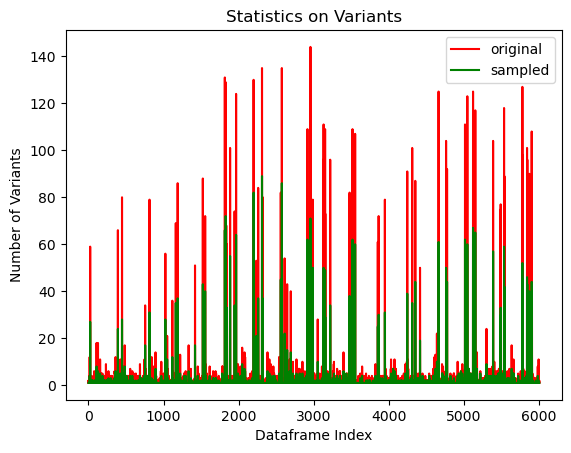

In [22]:
variant1 = []
variant2 = []
for log1, log2 in zip(logs, sampled_logs):
    variant = len(pm4py.get_variants(log1))
    variant1.append(variant)
    variant = len(pm4py.get_variants(log2))
    variant2.append(variant)
    
plot_distribution(variant1, variant2, 'Statistics on Variants', 'Number of Variants', 'variants.png')